In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import zscore
from math import atan2, cos, radians, sin, sqrt

In [ ]:
import plotly.express as px

In [ ]:
import mplcyberpunk

plt.style.use("cyberpunk")

In [ ]:
import seaborn as sns

# Intro

1) **Как обработали данные**

В первую очередь я проверил наличие NaN значений в данных и обнаружил, что в столбцах name, host_name, last_dt, avg_reviews есть NaN значения. В столбцах name и host_name я указывал вместо значения NaN значение ‘Unknown ‘, для avg_reviews вместо NaN вставлял 0, считая их просто неоценёнными, для last_dt я ставил минимальную дату в данных, так как если они есть, то как минимум изначально они точно были и могли никогда не бронироваться. Также для тех строк, где было значение NaN в last_dt, я добавил столбец has_last_dt и ставил в нём 1 если значение столбца last_dt не равно NaN. Дальше с помощью CatBoostEncoder я закодировал категориальные признаки, но также оставил не закодированые, так как буду использовать их при обучении CatBoostRegressor. Также был обработан столбец last_dt из него были выделены год, месяц, день, день недели, количество секунд между текущим значением last_dt и минимальным значением last_dt, прошлая дата обновления у объекта и разница в секундах между текущей датой и прошлой. Позже из-за распределения цены на объекты было принято решение логарифмировать цену объекта, однако тесты показали, что из-за этого модели выдают очень плохие результаты. Дальше я решил проанализировать хоста и вычислил у него среднюю и медианную цену на его объекты, и разницу между ценой текущего объекта и средними, а также медианными ценами. Продолжая работать с хостом, я вычислил среднюю оценку и среднее количество оценок его объектов и посчитал разницу этих средних с оценками и количество оценок отдельных объектов. Также захотелось поработать с разбиением на кластеры и посчитать среднюю цену на объекты в них, а также средние оценки и среднее количество оценок, чтобы сравнить объекты внутри кластеров, но так как данные у нас за несколько, то посчитаем эти средние по годам. После вычисления этих средних я посчитал разницу между ценами/оценками/количеством оценок и соответствующими средними внутри кластера. Важно оценить цену за сутки на объекты именно поэтому был добавлен признак, который показывал цену за сутки. Позже были отнормированы числовые признаки. Также была идея, которая выглядела хорошо, но она ухудшала модели и заключалась в том, чтобы из названий объектов находить слова, которые могут сигнализировать о хороших условиях объекта и добавить их в качестве признаков. Я думаю, прошлую идею можно доработать и сделать из этого один или пару столбцов, так как в моей реализацией их было много и это приводило к ухудшению результатов у модели. К сожалению, здесь я не успел реализовать отбор признаков.

2) **Какой алгоритм вы выбрали**

Я решил использовать для решения этой задачи классификации следующие 3 подхода:

а) lightautoml,
б) Ансамбли моделей (блендинг),
в) Один CatBoostRegressor.

Если говорить о lightautoml, то несмотря на увеличение timeout до почти двух часов он не смог дать хорошие результаты, так как на тренировочных данных он показывал хорошее значение mse, однако при сабмите выдавал не лучшие результаты. Из-за этого я не стал его использовать для финального решения. Переходя к ансамблям моделей, то я создавал несколько моделей первого уровня и тренировал их на 45% данных для получения их предсказаний на 45% и дальнейшего обучения на них мета модели с оценкой mse по оставшимся 10%. Для моделей первого уровня я брал CatBoostRegressor, LGBMRegressor, XGBRegressor, Ridge, Lasso, RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, а мета модель была. Также стоит отметить, что для моделей CatBoostRegressor, LGBMRegressor, XGBRegresso я подирал гиппепараметры с помощью hyperopt. Однако данный подход показал результаты хуже, чем один CatBoostRegressor. И в конце концов я выбрал CatBoostRegressor, так как он показывал самые устойчивые результаты, а также самые низкие результаты по mse.

3) **Какие особенности использовали при его обучении**

а) при обучении модели CatBoostRegressor в неё передавались категориальные признаки с помощью параметра cat_features, так как это помогает защитить модель от переобучения и снимает с нас работу кодирования категориальных признаков.

б) Также для подбора гиперпараметров iterations, learning_rate, depth, l2_leaf_reg, bagging_temperature я воспользовался Hyperopt.

в) Также при обучении я использовал параметры модели od_wait=100 и od_type='Iter', чтобы предотвратить переобучение.

г) В качестве метрик использовался RMSE, так как он подходит под метрику из соревнования.



4) **Как проводили валидацию алгоритма**

а) При подборе гиперпараметров в Hyperopt я использовал cross-validation с параметром cv=5, рассчитывая средней оценки метрики MSE для оценки модели, однако по итогу я выбрал подход с TimeSeriesSplit, так как он показывал результаты лучше. Так что в итоге была выбрана валидация по времени.

б) Также я пользовался оценкой модели на отложенной выборке, так как это помогало оценить качество модели на данных, которые она не видна.



# Outro

**Идеи улучшения:**

1)	Первая идея улучшения метрик будет использовать различных loss-функций и написание особых loss-функций для подбора лучшей для улучшения метрики MSE. Реализовать это можно с помощью внедрения их, как гипперпараметров, в Hyperopt, т.е. мы бы подбирали лучшую loss-функцию также, как и остальные гипперпараметры, в Hyperopt.
  
2)	Второй идеей будет использование других подходов при построении ансамбля моделей, так как кажется у нас не так много данных для построения ансамбля, который был у меня в коде. Именно поэтому я бы обучал модели на 80% процентах данных, а строил мета модель на предсказаниях остальных 20% данных, а также постарался бы подобрать гипперпараметры для всех моделей первого уровня, а также для мета модели.

3)	Третья идея улучшить данные, используя Exclusive Feature Bundling, т.е. объединять взаимоисключающие признаки, базируясь на определённом пороге разрежённости признаков. Также можно добавить отбор признаков по важности, используя функцию evaluate_feature_count, реализованную на 4 семинаре. Также доработать признак с положительными словами, так как кажется он может сильно улучшить результаты.



# Ваш ник на Kaggle и скриншот с итоговой позицией на leaderboard

ник ghgghg22, позиция 28

# Информация о столбцах

# Работа с данными

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
test['index'] = test.index

In [ ]:
len(df['name'].unique())

36077

**Основная статистика датафрейма**

In [ ]:
df.describe()

,_id,lat,lon,sum,min_days,amt_reviews,avg_reviews,total_host,target
count,3.667100e+04,36671.000000,36671.000000,36671.000000,36671.000000,36671.000000,29169.000000,36671.000000,36671.000000
mean,6.720433e+07,40.729080,-73.951958,152.142292,7.053176,23.433667,1.365601,7.047694,112.766628
std,7.828147e+07,0.054671,0.046201,239.107973,21.539569,44.703590,1.643966,32.595427,131.583284
min,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,7.780024e+06,40.690090,-73.982970,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,3.053256e+07,40.723150,-73.955560,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,1.074344e+08,40.763260,-73.935865,175.000000,5.000000,24.000000,2.010000,2.000000,227.000000
max,2.743213e+08,40.912340,-73.712990,10000.000000,1250.000000,629.000000,20.940000,327.000000,365.000000


In [ ]:
df.shape

(36671, 15)

**Типы столбцов**

In [ ]:
df.dtypes

name                 object
_id                   int64
host_name            object
location_cluster     object
location             object
lat                 float64
lon                 float64
type_house           object
sum                   int64
min_days              int64
amt_reviews           int64
last_dt              object
avg_reviews         float64
total_host            int64
target                int64
dtype: object

**Список категориальных столбцов и численных**

In [ ]:
infl_columns = df.select_dtypes(exclude='object').columns

In [ ]:
cat_columns = df.select_dtypes(include='object').columns

**Работат с NaN значениями**

Колонки с NaN значениями

In [ ]:
df.isna().sum()

name                   9
_id                    0
host_name             18
location_cluster       0
location               0
lat                    0
lon                    0
type_house             0
sum                    0
min_days               0
amt_reviews            0
last_dt             7502
avg_reviews         7502
total_host             0
target                 0
dtype: int64

Обработаем NaN значения

Для неуказанных host_name будем предполагать, что хост не заполнил эти данные

In [ ]:
df['host_name'] = np.where(df['host_name'].isna(), 'Unknown', df['host_name'])
test['host_name'] = np.where(test['host_name'].isna(), 'Unknown', test['host_name'])

Для неуказанных name будем предполагать, что хост не заполнил эти данные

In [ ]:
df['name'] = np.where(df['name'].isna(), 'Unknown', df['name'])
test['name'] = np.where(test['name'].isna(), 'Unknown', test['name'])

Посмотрим на столбец avg_reviews

In [ ]:
df.loc[df['avg_reviews'].isna(), 'amt_reviews'].unique()

array([0], dtype=int64)

In [ ]:
df.loc[df['avg_reviews'] == 0, 'amt_reviews'].unique()

array([], dtype=int64)

Видго, что в столбцах, где avg_reviews = NaN просто не было оценок. А также можно заметить, что нет в df значений у столбца avg_reviews=0, тогда заменим NaN на 0

In [ ]:
df['avg_reviews'] = np.where(df['avg_reviews'].isna(), 0, df['avg_reviews'])
test['avg_reviews'] = np.where(test['avg_reviews'].isna(), 0, test['avg_reviews'])

Посмотрим на столбец last_dt             

In [ ]:
df.loc[df['last_dt'].isna(), 'avg_reviews'].unique()

array([0.])

Значит данный жилье никогда не бронировалось и никогда не снималось

In [ ]:
df['has_last_dt'] = np.where(df['last_dt'].isna(), 0, 1)
test['has_last_dt'] = np.where(test['last_dt'].isna(), 0, 1)

In [ ]:
df['last_dt'] = np.where(df['last_dt'].isna(), '2012-01-03', df['last_dt'])
test['last_dt'] = np.where(test['last_dt'].isna(), '2012-01-03', test['last_dt'])

In [ ]:
df['last_dt'] = pd.to_datetime(df['last_dt'])
test['last_dt'] = pd.to_datetime(test['last_dt'])

**Рапспределение предсказываемого класса**

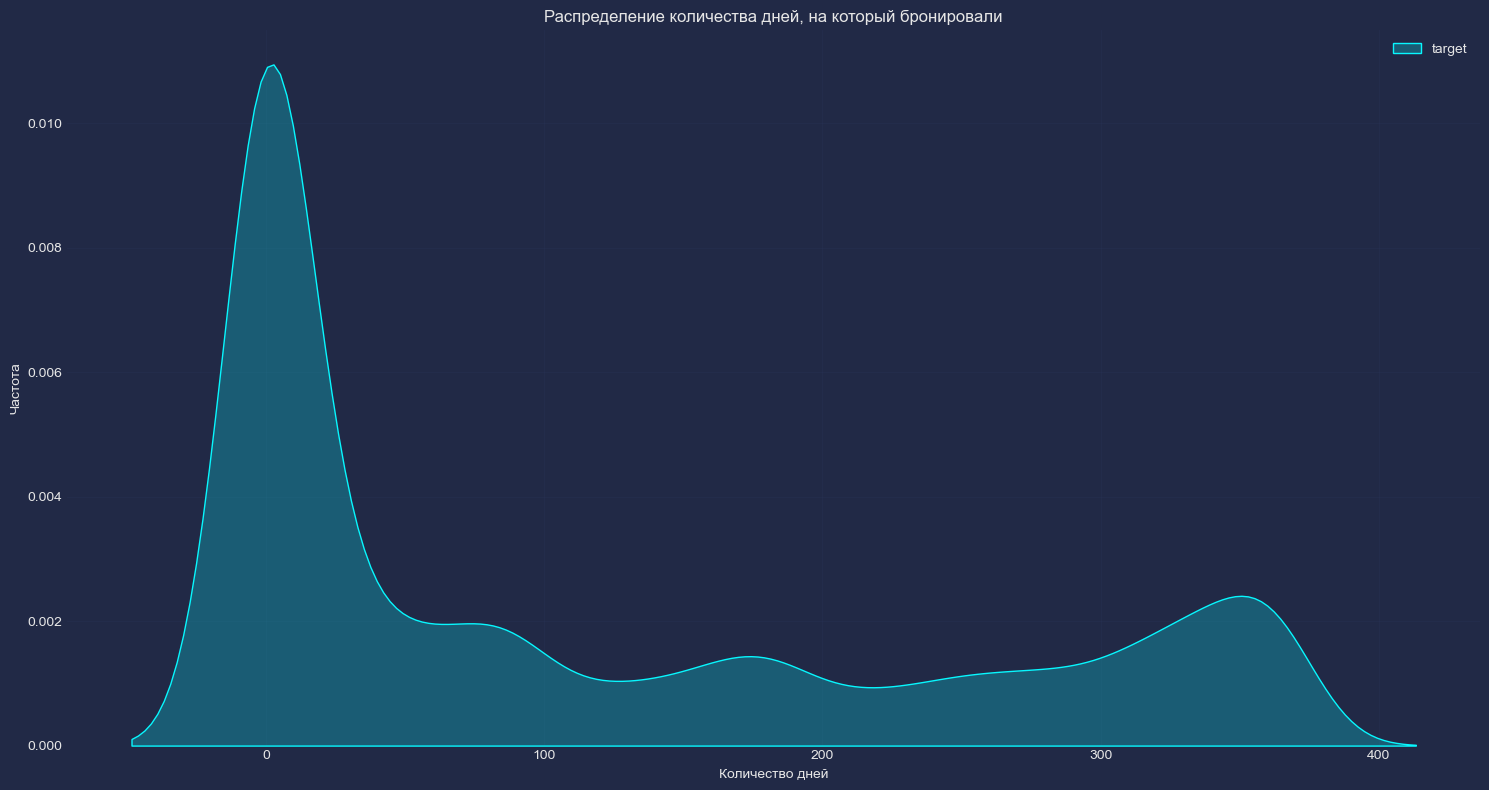

In [ ]:
plt.figure(figsize=(15, 8))
sns.kdeplot(df['target'], color='C0', fill=True, label='target')

plt.xlabel('Количество дней')
plt.ylabel('Частота')
plt.title('Распределение количества дней, на который бронировали')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# Feature Engineering

In [ ]:
#df.drop(columns = '_id', axis = 1, inplace=True)

In [ ]:
#test.drop(columns = '_id', axis = 1, inplace=True)

## Кодирование категориальных признаков

In [ ]:
cat_columns = df.select_dtypes(include='object').columns

In [ ]:
import category_encoders as ce

In [ ]:
target_enc = ce.CatBoostEncoder(cols=cat_columns)
target_enc = target_enc.fit(df[cat_columns],df['target'])
df = df.join(target_enc.transform(df[cat_columns]).add_suffix('_cb'))

In [ ]:
test = test.join(target_enc.transform(test[cat_columns]).add_suffix('_cb'))

In [ ]:
#df.drop(columns = cat_columns, axis = 1, inplace=True)

In [ ]:
#test.drop(columns = cat_columns, axis = 1, inplace=True)

## Время

In [ ]:
df['year'] = df['last_dt'].dt.year
test['year'] = test['last_dt'].dt.year

df['month'] = df['last_dt'].dt.month
test['month'] = test['last_dt'].dt.month

df['day'] = df['last_dt'].dt.day
test['day'] = test['last_dt'].dt.day

df['weekday'] = df['last_dt'].dt.weekday
test['weekday'] = test['last_dt'].dt.weekday

In [ ]:
df = df.sort_values(by='last_dt')

test = test.sort_values(by='last_dt')

In [ ]:
df['Time'] = df['last_dt'] - df['last_dt'].min()
df['Time'] = df['Time'].dt.total_seconds()

In [ ]:
test['Time'] = test['last_dt'] - df['last_dt'].min()
test['Time'] = test['Time'].dt.total_seconds()

In [ ]:
df['prev_time'] = df.groupby('name')['Time'].shift()
df['time_since_prev'] = (df['Time'] - df['prev_time'])

In [ ]:
test['prev_time'] = test.groupby('name')['Time'].shift()
test['time_since_prev'] = (test['Time'] - test['prev_time'])

In [ ]:
df['time_since_prev'] = df['time_since_prev'].fillna(-1)
df.drop(columns ='prev_time' , axis = 1, inplace=True)

In [ ]:
test['time_since_prev'] = test['time_since_prev'].fillna(-1)
test.drop(columns ='prev_time' , axis = 1, inplace=True)

## Логирофмирование цены

In [ ]:
# df['sum'] = np.where(df['sum'] == 0, 1, df['sum'])

In [ ]:
# df['sum'] = np.log(df['sum'])

In [ ]:
# test['sum'] = np.where(test['sum'] == 0, 1, test['sum'])

In [ ]:
# test['sum'] = np.log(test['sum'])

## Тотал статистики по хосту

In [ ]:
df_total_host = df.loc[::, ['host_name', 'sum']].groupby(by='host_name').agg({'sum': ['mean', 'median']}).reset_index()

test_total_host = test.loc[::, ['host_name', 'sum']].groupby(by='host_name').agg({'sum': ['mean', 'median']}).reset_index()

In [ ]:
df_total_host.columns = ['_'.join(col).strip('_') for col in df_total_host.columns.values]

test_total_host.columns = ['_'.join(col).strip('_') for col in test_total_host.columns.values]


In [ ]:
df = df.merge(df_total_host, how='inner', on='host_name')

test = test.merge(test_total_host, how='inner', on='host_name')

In [ ]:
df['diff_sum_host'] = df['sum'] - df['sum_mean']

In [ ]:
test['diff_sum_host'] = test['sum'] - test['sum_mean']

## Средний рейтинг хоста


In [ ]:
df_house_actual = df.loc[::, ['name', 'last_dt']].groupby(by='name').max().reset_index()

test_house_actual = test.loc[::, ['name', 'last_dt']].groupby(by='name').max().reset_index()

In [ ]:
df_house_actual.columns  = ['name', 'last_dt_actual']

test_house_actual.columns  = ['name', 'last_dt_actual']

In [ ]:
df = df.merge(df_house_actual, how='inner', on='name')

test = test.merge(test_house_actual, how='inner', on='name')

In [ ]:
df_rating_host = df.loc[df['last_dt'] == df['last_dt_actual'], ['host_name', 'avg_reviews', 'amt_reviews']].groupby(by='host_name').mean().reset_index()

test_rating_host = test.loc[test['last_dt'] == test['last_dt_actual'], ['host_name', 'avg_reviews', 'amt_reviews']].groupby(by='host_name').mean().reset_index()

In [ ]:
df_rating_host.columns = ['host_name', 'avg_reviews_total', 'amt_reviews_total']

In [ ]:
test_rating_host.columns = ['host_name', 'avg_reviews_total', 'amt_reviews_total']

In [ ]:
df = df.merge(df_rating_host, how='left', on='host_name')

test = test.merge(test_rating_host, how='left', on='host_name')

In [ ]:
df['diff_avg_reviews_host'] = df['avg_reviews'] - df['avg_reviews_total']

test['diff_avg_reviews_host'] = test['avg_reviews_total'] - test['avg_reviews_total']

In [ ]:
df['diff_amt_reviews_host'] = df['amt_reviews'] - df['amt_reviews_total']

test['diff_amt_reviews_host'] = test['amt_reviews'] - test['amt_reviews_total']

## Информация о кластере

In [ ]:
df['mean_sum_location_cluster_year'] = df.groupby(['location_cluster', 'year'])['sum'].expanding().mean().reset_index(level=[0,1], drop=True)

test['mean_sum_location_cluster_year'] = test.groupby(['location_cluster', 'year'])['sum'].expanding().mean().reset_index(level=[0,1], drop=True)

In [ ]:
df['mean_avg_reviews_total_location_cluster_year'] = df.groupby(['location_cluster', 'year'])['avg_reviews_total'].expanding().mean().reset_index(level=[0,1], drop=True)

test['mean_avg_reviews_total_location_cluster_year'] = test.groupby(['location_cluster', 'year'])['avg_reviews_total'].expanding().mean().reset_index(level=[0,1], drop=True)


In [ ]:
df['mean_amt_reviews_total_location_cluster_year'] = df.groupby(['location_cluster', 'year'])['amt_reviews_total'].expanding().mean().reset_index(level=[0,1], drop=True)

test['mean_amt_reviews_total_location_cluster_year'] = test.groupby(['location_cluster', 'year'])['amt_reviews_total'].expanding().mean().reset_index(level=[0,1], drop=True)


In [ ]:
df['diff_cluster_sum'] = df['sum'] - df['mean_sum_location_cluster_year']

test['diff_cluster_sum'] = test['sum'] - test['mean_sum_location_cluster_year']

In [ ]:
df['diff_cluster_avg_reviews_total'] = df['avg_reviews_total'] - df['mean_avg_reviews_total_location_cluster_year']

test['diff_cluster_avg_reviews_total'] = test['avg_reviews_total'] - test['mean_avg_reviews_total_location_cluster_year']

In [ ]:
df['diff_cluster_amt_reviews_total'] = df['amt_reviews_total'] - df['mean_amt_reviews_total_location_cluster_year']

test['diff_cluster_amt_reviews_total'] = test['amt_reviews_total'] - test['mean_amt_reviews_total_location_cluster_year']

## Цена за сутки

In [ ]:
df['price_per_day'] = df['sum'] / df['min_days']

test['price_per_day'] = test['sum'] / test['min_days']

In [ ]:
df = df.fillna(0)
test = test.fillna(0)

## Маштибирование прзинаков

In [ ]:
from sklearn.preprocessing import StandardScaler


In [ ]:
infl_columns = df.select_dtypes(exclude='object').columns

In [ ]:
infl_columns1 = []
for cat in infl_columns:
    if (cat !='last_dt') & (cat !='target') & (cat !='last_dt_actual'):
        infl_columns1.append(cat)

In [ ]:
scaler = StandardScaler()
scaler.fit(df[infl_columns1])
df[infl_columns1] = scaler.transform(df[infl_columns1])

In [ ]:
test[infl_columns1] = scaler.transform(test[infl_columns1])

## Положительные слова в названии, которые могут сигнализировать о хорошом качестве квартиры

In [ ]:
# positive_words = [
#     # Комфорт / Интерьер
#     "beautiful", "cozy", "modern", "spacious", "stylish", "elegant", "charming",
#     "warm", "inviting", "comfortable", "luxury", "renovated", "bright", "clean",
#     "minimalist", "sleek", "well-designed",

#     # Расположение / Вид
#     "central", "downtown", "heart of city", "close to metro", "close to center",
#     "great location", "sea view", "city view", "panoramic", "sunny", "quiet",
#     "green area", "near park",

#     # Уникальность / Удобства
#     "unique", "authentic", "high ceilings", "balcony", "terrace", "private",
#     "studio", "loft", "historic", "pet friendly", "family friendly", "fully equipped",

#     # Для деловых / удалённых
#     "wifi", "workspace", "desk", "business", "remote work",

#     # Отдых и атмосфера
#     "romantic", "relaxing", "weekend", "getaway", "retreat"
# ]

In [ ]:
# def extract_keywords_features(df, column='name', keywords=positive_words):
#     df[column] = df[column].astype(str).str.lower()
#     for word in keywords:
#         flag_name = f'has_{word.replace(" ", "_")}'
#         df[flag_name] = df[column].str.contains(rf'\b{word}\b', regex=True).astype(int)
#     return df
# extract_keywords_features(df)

In [ ]:
# extract_keywords_features(test)

# Построим матрицу корреляции для числовых признаков

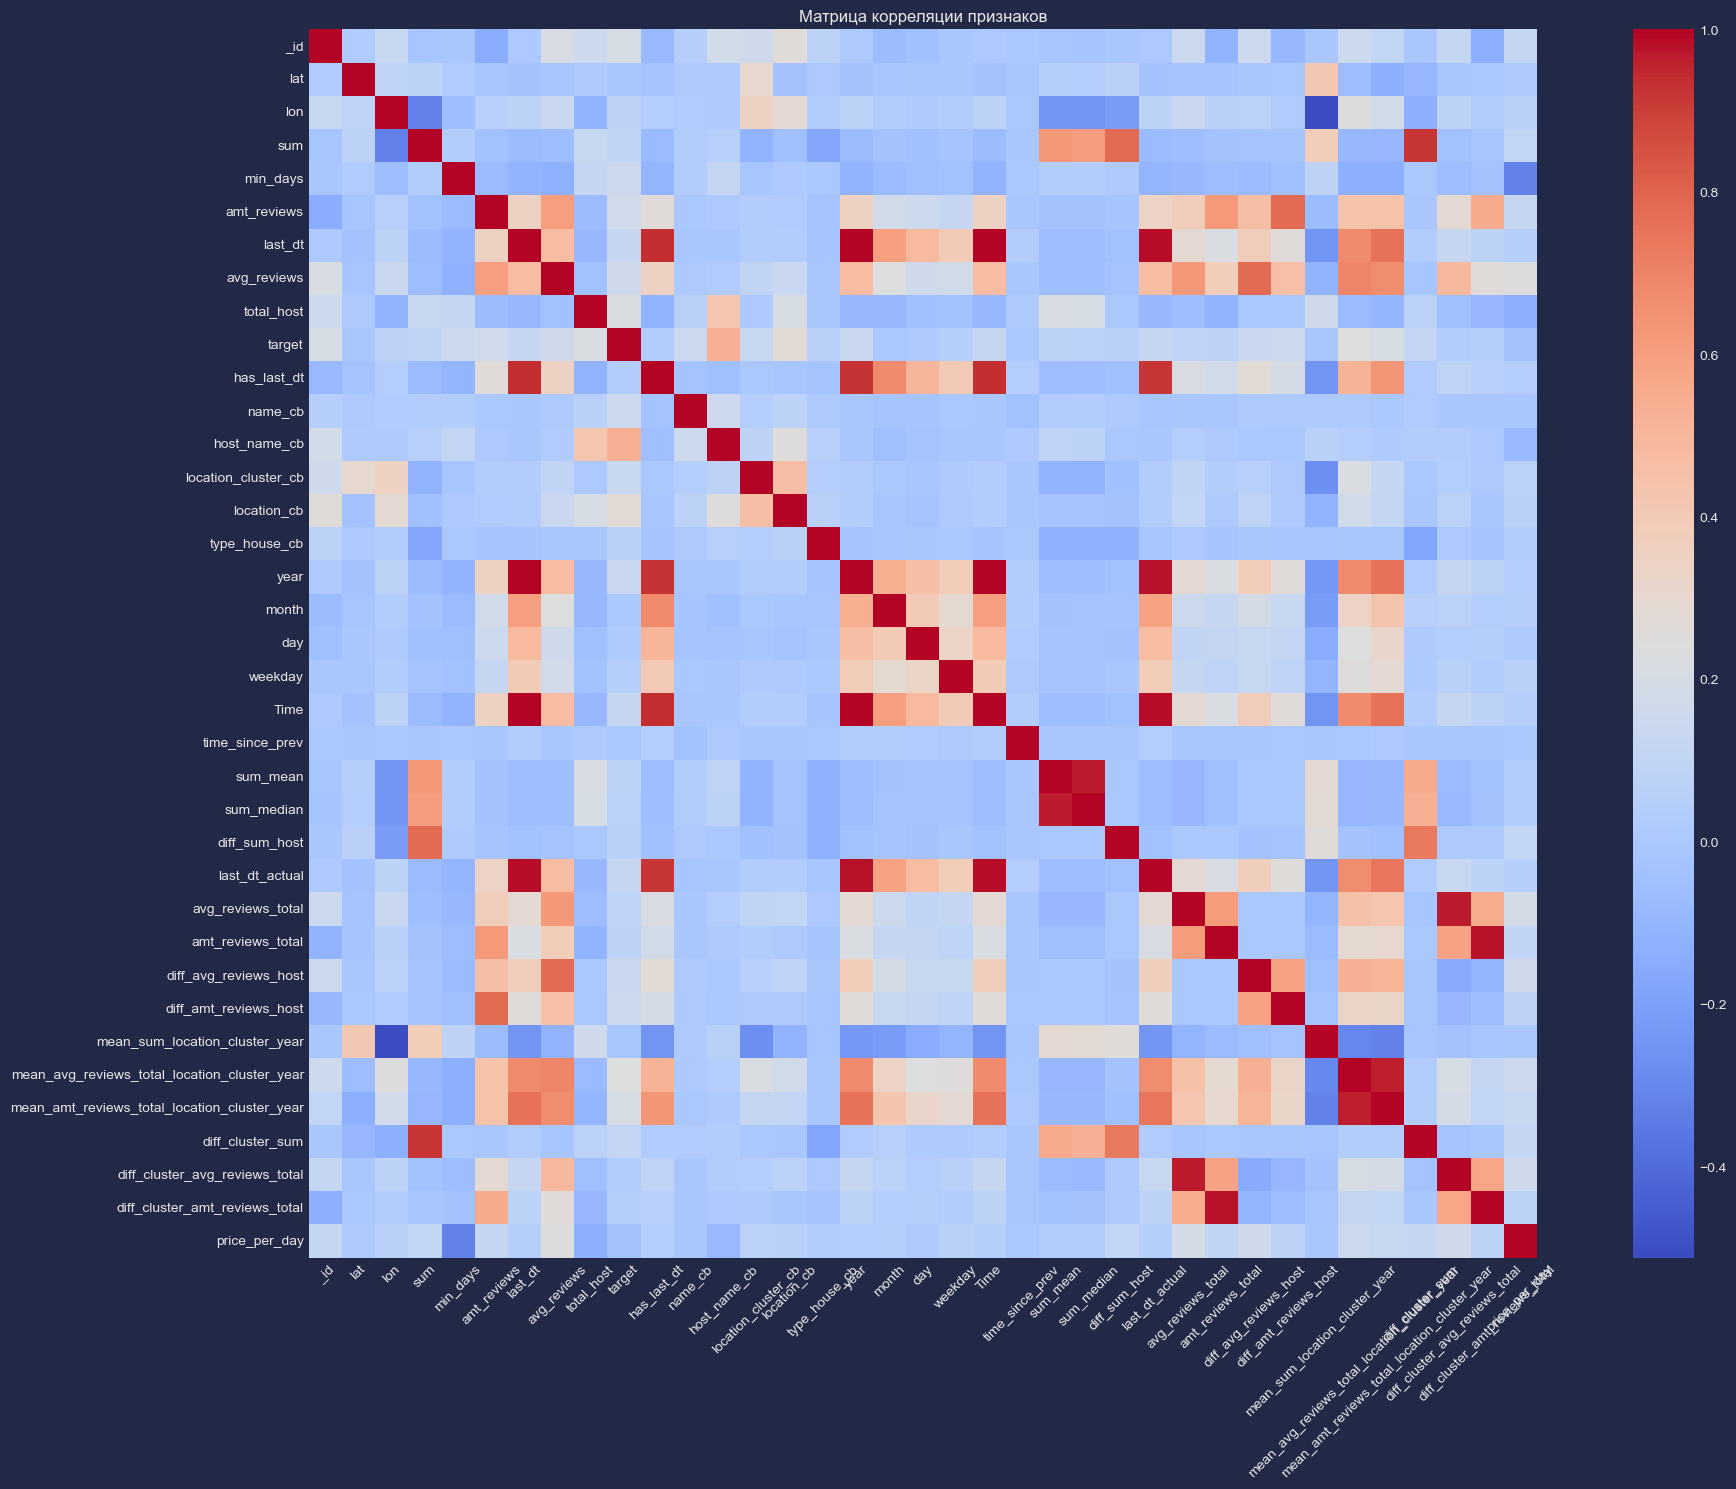

In [ ]:
corr_matrix = df.loc[::,infl_columns].corr()
plt.figure(figsize=(21, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0, square=True)
plt.title('Матрица корреляции признаков')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
model_features_all = ['location_cluster', 'location', 'lat',
       'lon', 'type_house', 'sum', 'min_days', 'amt_reviews',
       'avg_reviews', 'total_host',  'has_last_dt', 'location_cluster_cb', 'location_cb', 'type_house_cb',
       'year', 'month', 'day', 'weekday', 'Time', 'time_since_prev',
       'sum_mean', 'sum_median', 'diff_sum_host',
       'avg_reviews_total', 'amt_reviews_total', 'diff_avg_reviews_host',
       'diff_amt_reviews_host', 'mean_sum_location_cluster_year',
       'mean_avg_reviews_total_location_cluster_year',
       'mean_amt_reviews_total_location_cluster_year', 'diff_cluster_sum',
       'diff_cluster_avg_reviews_total', 'diff_cluster_amt_reviews_total',
       'price_per_day']

In [ ]:
model_features_other = [ 'lat',
       'lon', 'sum', 'min_days', 'amt_reviews',
       'avg_reviews', 'total_host', 'has_last_dt'
        , 'location_cluster_cb', 'location_cb', 'type_house_cb',
       'year', 'month', 'day', 'weekday', 'Time', 'time_since_prev',
       'sum_mean', 'sum_median', 'diff_sum_host',
       'avg_reviews_total', 'amt_reviews_total', 'diff_avg_reviews_host',
       'diff_amt_reviews_host', 'mean_sum_location_cluster_year',
       'mean_avg_reviews_total_location_cluster_year',
       'mean_amt_reviews_total_location_cluster_year', 'diff_cluster_sum',
       'diff_cluster_avg_reviews_total', 'diff_cluster_amt_reviews_total',
       'price_per_day']

In [ ]:
model_features_cat = ['location_cluster', 'location', 'lat',
       'lon', 'type_house', 'sum', 'min_days', 'amt_reviews',
       'avg_reviews', 'total_host',  'has_last_dt',
       'year', 'month', 'day', 'weekday', 'Time', 'time_since_prev',
       'sum_mean', 'sum_median', 'diff_sum_host',
       'avg_reviews_total', 'amt_reviews_total', 'diff_avg_reviews_host',
       'diff_amt_reviews_host', 'mean_sum_location_cluster_year',
       'mean_avg_reviews_total_location_cluster_year',
       'mean_amt_reviews_total_location_cluster_year', 'diff_cluster_sum',
       'diff_cluster_avg_reviews_total', 'diff_cluster_amt_reviews_total',
       'price_per_day']

# Библиотеки

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier, Pool
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
X, y = df.loc[::, model_features_all].copy(), df['target']

# Auto ml

In [ ]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [ ]:
X_train_auto, X_test__auto, y_train_auto, y_test_onlu_auto = train_test_split(X.loc[::,model_features_cat], y, test_size=0.1, random_state=2025)

In [ ]:
X_train_auto['target'] = y_train_auto

In [ ]:
automl = TabularAutoML(task = Task(name='reg', metric='mse'), timeout=2000)

In [ ]:
oof_preds = automl.fit_predict(X_train_auto, roles = {'target': 'target'}).data

In [ ]:
test_preds = automl.predict(X_test__auto).data

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_onlu_auto, test_preds)

10079.3603515625

# Свой ансамбль

## Подготовка данных для ансамбля

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.40, random_state=13)

In [ ]:
X_train_cat = X_train.loc[::, model_features_cat].copy()
X_test_cat = X_test.loc[::, model_features_cat].copy()

In [ ]:
X_train_other = X_train.loc[::, model_features_other].copy()
X_test_other = X_test.loc[::, model_features_other].copy()

In [ ]:
X_val_other = X_val.loc[::, model_features_other].copy()
X_val_cat = X_val.loc[::, model_features_cat].copy()

In [ ]:
test = test.sort_values(by='index')

In [ ]:
main_test_cat= test.loc[::, model_features_cat].copy()
main_test_other = test.loc[::, model_features_other].copy()

In [ ]:
cat_columns_end = []
for i in range(len(cat_columns)):
    if cat_columns[i] in model_features_cat:
        cat_columns_end.append(cat_columns[i])

## CatBoostRegressor

In [ ]:
import time
from tqdm import tqdm

In [ ]:
import time
import numpy as np
from catboost import CatBoostRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Пример: допустим, у вас есть X_train, y_train, X_test, y_test
# и список категориальных признаков cat_columns_end

print("\nЗапуск Hyperopt...")
start_time_hyperopt = time.time()

# Пространство гиперпараметров
space = {
    'iterations': hp.quniform('iterations', 200, 1000, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.9),
    'depth': hp.quniform('depth', 3, 5, 1),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 0.1, 10.1, 1),
    'bagging_temperature': hp.quniform('bagging_temperature', 0.1, 1, 0.4)
}

# Целевая функция для Hyperopt
def objective(params):
    # Преобразуем часть параметров к целым
    model_params = {
        'iterations': int(params['iterations']),
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'l2_leaf_reg': params['l2_leaf_reg'],
        'bagging_temperature': params['bagging_temperature'],
        'cat_features': cat_columns_end,
        'od_wait': 100
    }

    # Создаем регрессионную модель
    model = CatBoostRegressor(**model_params)

    # Выполняем кросс-валидацию с метрикой 'neg_mean_squared_error'
    scores = cross_val_score(model, X_train_cat, y_train,
                             cv=5,
                             scoring='neg_mean_squared_error',
                             n_jobs=-1)

    # MSE получается со знаком «-», берём среднее и переворачиваем знак
    mse_mean = -np.mean(scores)

    # Обновляем прогресс-бар
    hyperopt_pbar.update(1)

    # Возвращаем значение MSE, которое Hyperopt будет минимизировать
    return {'loss': mse_mean, 'status': STATUS_OK, 'params': model_params}

# Запускаем Hyperopt
n_iter_hyperopt = 30
hyperopt_pbar = tqdm(total=n_iter_hyperopt, desc="Hyperopt")

trials = Trials()
best_hyperopt = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=n_iter_hyperopt,
    trials=trials,
    verbose=0
)

hyperopt_pbar.close()

# Находим индекс лучшего trial
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_params_hyperopt1 = trials.trials[best_trial_idx]['result']['params']

# Лучшее значение среднеквадратичной ошибки (MSE) на кросс-валидации
best_score_hyperopt = min([t['result']['loss'] for t in trials.trials])
time_hyperopt = time.time() - start_time_hyperopt

# Обучаем финальную модель на всей обучающей выборке
best_model_hyperopt = CatBoostRegressor(**best_params_hyperopt1)
best_model_hyperopt.fit(X_train_cat, y_train)

# Предсказания на тесте
y_test_pred_hyperopt = best_model_hyperopt.predict(X_test_cat)

# Считаем MSE на тесте
mse_test = mean_squared_error(y_test, y_test_pred_hyperopt)

print(f"\nHyperopt завершен за {time_hyperopt:.2f} секунд")
print(f"Лучшие параметры: {best_params_hyperopt1}")
print(f"Лучший CV MSE: {best_score_hyperopt:.4f}")
print(f"MSE на тестовых данных: {mse_test:.4f}")



Запуск Hyperopt...


Hyperopt: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [11:45<00:00, 23.50s/it]


0:	learn: 128.5349524	total: 158ms	remaining: 1m 26s
1:	learn: 125.5912551	total: 181ms	remaining: 49.7s
2:	learn: 123.0152108	total: 204ms	remaining: 37.1s
3:	learn: 120.7595266	total: 227ms	remaining: 31s
4:	learn: 118.9698310	total: 249ms	remaining: 27.2s
5:	learn: 117.4538315	total: 270ms	remaining: 24.5s
6:	learn: 116.1402617	total: 292ms	remaining: 22.6s
7:	learn: 115.0406199	total: 321ms	remaining: 21.8s
8:	learn: 114.0863313	total: 351ms	remaining: 21.1s
9:	learn: 113.2122833	total: 388ms	remaining: 20.9s
10:	learn: 112.5311126	total: 416ms	remaining: 20.4s
11:	learn: 111.9328804	total: 442ms	remaining: 19.8s
12:	learn: 111.3648731	total: 470ms	remaining: 19.4s
13:	learn: 110.8996936	total: 491ms	remaining: 18.8s
14:	learn: 110.3772932	total: 515ms	remaining: 18.4s
15:	learn: 109.9461220	total: 535ms	remaining: 17.9s
16:	learn: 109.6463851	total: 558ms	remaining: 17.5s
17:	learn: 109.3418628	total: 579ms	remaining: 17.1s
18:	learn: 109.0337212	total: 602ms	remaining: 16.8s
19:	

In [ ]:
best_params_hyperopt1

{'iterations': 550,
 'depth': 5,
 'learning_rate': 0.10083522391139502,
 'l2_leaf_reg': 3.0,
 'bagging_temperature': 0.0,
 'cat_features': ['location_cluster', 'location', 'type_house'],
 'od_wait': 100}

In [ ]:
cat_clf_tuned = CatBoostRegressor(**best_params_hyperopt1, eval_metric='RMSE', verbose=0)
cat_clf_tuned.fit(X_train_cat, y_train)

In [ ]:
cat_clf_tuned = CatBoostRegressor(**best_params_hyperopt1, eval_metric='RMSE', verbose=0)
cat_clf_tuned.fit(X_train_cat, y_train)
mean_squared_error(y_test,  cat_clf_tuned.predict(X_test_cat))

10119.86632429386

In [ ]:
mean_squared_error(y_test,  cat_clf_tuned.predict(X_test_cat))

10119.86632429386

## LGBMRegressor

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from tqdm import tqdm
import lightgbm as lgb

# Допустим, у нас есть:
# X_train, y_train, X_test, y_test — обучающая и тестовая выборки
# Пример кода для оптимизации

print("\nЗапуск Hyperopt для LGBM...")
start_time_hyperopt = time.time()

# Пространство гиперпараметров LGBM
space = {
    'n_estimators': hp.quniform('n_estimators', 200, 1000, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 31, 63, 1),
    'max_depth': hp.quniform('max_depth', 3, 6, 1),
    'min_child_samples': hp.quniform('min_child_samples', 5, 50, 1),
    # при необходимости добавляйте другие параметры (subsample, colsample_bytree и т.д.)
}

# Целевая функция для Hyperopt
def objective(params):
    # Округляем часть параметров до целых значений
    params['n_estimators'] = int(params['n_estimators'])
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_samples'] = int(params['min_child_samples'])

    # Создаём модель LGBMRegressor
    model = lgb.LGBMRegressor(**params)

    # Кросс-валидация с метрикой MSE
    scores = cross_val_score(model, X_train_other, y_train,
                             cv=5,
                             scoring='neg_mean_squared_error',
                             n_jobs=-1)
    # Из-за 'neg_mean_squared_error' результат scores будет отрицательным,
    # поэтому берём со знаком «-», чтобы получить MSE
    mse_mean = -np.mean(scores)

    # Обновляем прогресс-бар
    hyperopt_pbar.update(1)

    # Возвращаем MSE, которое Hyperopt будет минимизировать
    return {'loss': mse_mean, 'status': STATUS_OK, 'params': params}

# Запускаем оптимизацию Hyperopt
n_iter_hyperopt = 30
hyperopt_pbar = tqdm(total=n_iter_hyperopt, desc="Hyperopt")

trials = Trials()
best_hyperopt = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=n_iter_hyperopt,
    trials=trials,
    verbose=0
)

hyperopt_pbar.close()

# Находим индекс лучшего набора параметров
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_params_hyperopt2 = trials.trials[best_trial_idx]['result']['params']

# Лучшее значение MSE по кросс-валидации
best_score_hyperopt = min([t['result']['loss'] for t in trials.trials])
time_hyperopt = time.time() - start_time_hyperopt

# Обучаем финальную модель на всей обучающей выборке
best_model_hyperopt = lgb.LGBMRegressor(**best_params_hyperopt2, verbose=0)
best_model_hyperopt.fit(X_train_other, y_train)

# Предсказание на тестовой выборке и вычисление MSE
y_test_pred_hyperopt = best_model_hyperopt.predict(X_test_other)
mse_test = mean_squared_error(y_test, y_test_pred_hyperopt)

print(f"\nHyperopt завершен за {time_hyperopt:.2f} секунд")
print(f"Лучшие параметры: {best_params_hyperopt2}")
print(f"Лучший CV MSE: {best_score_hyperopt:.4f}")
print(f"MSE на тестовых данных: {mse_test:.4f}")



Запуск Hyperopt для LGBM...


Hyperopt: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [02:00<00:00,  4.01s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
best_params_hyperopt2

{'learning_rate': 0.01853368143584387,
 'max_depth': 6,
 'min_child_samples': 16,
 'n_estimators': 950,
 'num_leaves': 49}

In [ ]:
from lightgbm import LGBMRegressor

lgbm_clf_tuned = LGBMRegressor(**best_params_hyperopt2, objective='regression', metric='rmse', verbose=-1)
lgbm_clf_tuned.fit(X_train_other, y_train)


LGBMRegressor(learning_rate=0.01853368143584387, max_depth=6, metric='rmse',
              min_child_samples=16, n_estimators=950, num_leaves=49,
              objective='regression', verbose=-1)

In [ ]:
mean_squared_error(y_test,  lgbm_clf_tuned.predict(X_test_other))

9996.0198624

## XGBRegressor

In [ ]:
import time
import numpy as np
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from tqdm import tqdm
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

print("\nЗапуск Hyperopt для XGBoost...")
start_time_hyperopt = time.time()

# Допустим, у нас уже есть:
# X_train, y_train, X_test, y_test — обучающие и тестовые выборки.

# Пространство гиперпараметров для XGBRegressor
space = {
    'n_estimators': hp.quniform('n_estimators', 200, 1000, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'max_depth': hp.quniform('max_depth', 2, 6, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    # при необходимости можно добавить 'gamma', 'reg_alpha', 'reg_lambda' и т.д.
}

# Целевая функция для Hyperopt
def objective(params):
    # Округляем некоторые параметры, которые должны быть целыми
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])

    # Создаем XGBRegressor
    model = XGBRegressor(
        **params,
        # Параметры, улучшающие вывод/обучение
        verbosity=0,
        use_label_encoder=False,
        objective='reg:squarederror'  # регрессия по умолчанию (MSE)
    )

    # Кросс-валидация (MSE со знаком минус)
    scores = cross_val_score(
        model,
        X_train_other,
        y_train,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Превращаем в положительный MSE
    mse_mean = -np.mean(scores)

    # Обновляем прогресс-бар
    hyperopt_pbar.update(1)

    # Возвращаем MSE, которое Hyperopt будет минимизировать
    return {'loss': mse_mean, 'status': STATUS_OK, 'params': params}

# Запускаем Hyperopt
n_iter_hyperopt = 30
hyperopt_pbar = tqdm(total=n_iter_hyperopt, desc="Hyperopt")

trials = Trials()
best_hyperopt = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=n_iter_hyperopt,
    trials=trials,
    verbose=0
)

hyperopt_pbar.close()

# Находим индекс лучшего результата
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_params_hyperopt3 = trials.trials[best_trial_idx]['result']['params']

# Лучшее значение MSE (минимальное) по кросс-валидации
best_score_hyperopt = min([t['result']['loss'] for t in trials.trials])
time_hyperopt = time.time() - start_time_hyperopt

# Обучаем финальную модель на всей обучающей выборке
best_model_hyperopt = XGBRegressor(
    **best_params_hyperopt3,
    verbosity=0,
    use_label_encoder=False,
    objective='reg:squarederror'
)
best_model_hyperopt.fit(X_train_other, y_train)

# Предсказания на тесте и вычисление MSE
y_test_pred_hyperopt = best_model_hyperopt.predict(X_test_other)
mse_test = mean_squared_error(y_test, y_test_pred_hyperopt)

print(f"\nHyperopt завершен за {time_hyperopt:.2f} секунд")
print(f"Лучшие параметры: {best_params_hyperopt3}")
print(f"Лучший CV MSE: {mse_test:.4f}")
print(f"MSE на тестовых данных: {mse_test:.4f}")



Запуск Hyperopt для XGBoost...


Hyperopt: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [01:29<00:00,  2.99s/it]



Hyperopt завершен за 89.77 секунд
Лучшие параметры: {'colsample_bytree': 0.842985430871844, 'learning_rate': 0.02904766504941679, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 650, 'subsample': 0.5629115003441212}
Лучший CV MSE: 10023.3516
MSE на тестовых данных: 10023.3516


In [ ]:
from xgboost import XGBRegressor

xgb_clf_tuned = XGBRegressor(**best_params_hyperopt3, eval_metric='rmse', verbosity=0)
xgb_clf_tuned.fit(X_train_other, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.842985430871844, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02904766504941679,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=650, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
mean_squared_error(y_test,  xgb_clf_tuned.predict(X_test_other))

10023.3515625

## Ещё несколько моделей первого уровня

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor


In [ ]:
models_many = [Ridge(), Lasso(), RandomForestRegressor(max_depth=6), GradientBoostingRegressor(), ExtraTreesRegressor(max_depth=6)]

In [ ]:
i = 0
arr_i = []
preds = []
for model_zero in models_many:
    print(i)
    model_zero.fit(X_train_other, y_train)
    print(mean_squared_error(y_test, model_zero.predict(X_test_other)))
    preds.append(mean_squared_error(y_test, model_zero.predict(X_test_other)))
    i+=1

0
13332.646410141479
1
13414.73601041049
2
11054.276096748988
3
10640.247002850887
4
12152.223460799358


In [ ]:
base_models = [cat_clf_tuned, lgbm_clf_tuned, xgb_clf_tuned]


In [ ]:
for model_zero in models_many:
    base_models.append(model_zero)

## Обучение ансамбля

In [ ]:
preds_val = []
preds_test = []
preds_main_test = []

for i in range(len(base_models)):
    print(i)
    try:
        if i==0:
            preds_val.append(base_models[i].predict(X_val_cat).reshape(-1,1))
            preds_test.append(base_models[i].predict(X_test_cat).reshape(-1,1))
            preds_main_test.append(base_models[i].predict(main_test_cat).reshape(-1,1))
        else:
            preds_val.append(base_models[i].predict(X_val_other).reshape(-1,1))
            preds_test.append(base_models[i].predict(X_test_other).reshape(-1,1))
            preds_main_test.append(base_models[i].predict(main_test_other).reshape(-1,1))
    except AttributeError:
        continue

0
1
2
3
4
5
6
7


In [ ]:
stacked_preds_val = np.hstack(preds_val)
stacked_preds_test = np.hstack(preds_test)
stacked_preds_main_test = np.hstack(preds_main_test)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor


In [ ]:
meta_model = Ridge()
meta_model.fit(stacked_preds_val, y_val)

final_preds = meta_model.predict(stacked_preds_test)

mse = mean_squared_error(y_test, final_preds)


print(f"RMSE финального ансамбля на data_3: {mse:.4f}")

RMSE финального ансамбля на data_3: 9919.8148


# Один catbost

In [ ]:
cat_columns_end = []
for i in range(len(cat_columns)):
    if cat_columns[i] in model_features_cat:
        cat_columns_end.append(cat_columns[i])

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
X_train_onlu_cat1, X_test_onlu_cat1, y_train_onlu_cat, y_test_onlu_cat = train_test_split(X, y, test_size=0.1, random_state=2025)

In [ ]:
X_train_onlu_cat = X_train_onlu_cat1.loc[::, model_features_cat].copy()
X_test_onlu_cat = X_test_onlu_cat1.loc[::, model_features_cat].copy()

In [ ]:
X_train_onlu_other = X_train_onlu_cat1.loc[::, model_features_other].copy()
X_test_onlu_other = X_test_onlu_cat1.loc[::, model_features_other].copy()

In [ ]:
import time
import numpy as np
from catboost import CatBoostRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Пример: допустим, у вас есть X_train, y_train, X_test, y_test
# и список категориальных признаков cat_columns_end

print("\nЗапуск Hyperopt...")
start_time_hyperopt = time.time()

# Пространство гиперпараметров
space = {
    'iterations': hp.quniform('iterations', 200, 1000, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.9),
    'depth': hp.quniform('depth', 3, 6, 1),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 0.1, 10.1, 1),
    'bagging_temperature': hp.quniform('bagging_temperature', 0.1, 1, 0.4)
}

# Целевая функция для Hyperopt
def objective(params):
    # Преобразуем часть параметров к целым
    model_params = {
        'iterations': int(params['iterations']),
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'l2_leaf_reg': params['l2_leaf_reg'],
        'bagging_temperature': params['bagging_temperature'],
        'cat_features': cat_columns_end,
        'od_wait': 100
    }

    # Создаем регрессионную модель
    model = CatBoostRegressor(**model_params)

    # Выполняем кросс-валидацию с метрикой 'neg_mean_squared_error'
    scores = cross_val_score(model, X_train_onlu_cat, y_train_onlu_cat,
                             cv=tscv,
                             scoring='neg_mean_squared_error',
                             n_jobs=-1)

    # MSE получается со знаком «-», берём среднее и переворачиваем знак
    mse_mean = -np.mean(scores)

    # Обновляем прогресс-бар
    hyperopt_pbar.update(1)

    # Возвращаем значение MSE, которое Hyperopt будет минимизировать
    return {'loss': mse_mean, 'status': STATUS_OK, 'params': model_params}

# Запускаем Hyperopt
n_iter_hyperopt = 30
hyperopt_pbar = tqdm(total=n_iter_hyperopt, desc="Hyperopt")

trials = Trials()
best_hyperopt = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=n_iter_hyperopt,
    trials=trials,
    verbose=0
)

hyperopt_pbar.close()

# Находим индекс лучшего trial
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_params_hyperoptend = trials.trials[best_trial_idx]['result']['params']

# Лучшее значение среднеквадратичной ошибки (MSE) на кросс-валидации
best_score_hyperopt = min([t['result']['loss'] for t in trials.trials])
time_hyperopt = time.time() - start_time_hyperopt

# Обучаем финальную модель на всей обучающей выборке
best_model_hyperopt = CatBoostRegressor(**best_params_hyperoptend)
best_model_hyperopt.fit(X_train_onlu_cat, y_train_onlu_cat)

# Предсказания на тесте
y_test_pred_hyperopt = best_model_hyperopt.predict(X_test_onlu_cat)

# Считаем MSE на тесте
mse_test = mean_squared_error(y_test_onlu_cat, y_test_pred_hyperopt)

print(f"\nHyperopt завершен за {time_hyperopt:.2f} секунд")
print(f"Лучшие параметры: {best_params_hyperoptend}")
print(f"Лучший CV MSE: {best_score_hyperopt:.4f}")
print(f"MSE на тестовых данных: {mse_test:.4f}")



Запуск Hyperopt...



Hyperopt:   0%|                                                                                 | 0/30 [00:23<?, ?it/s]

Hyperopt: 100%|████████████████████████████████████████████████████████████████████████| 30/30 [12:38<00:00, 25.29s/it]


0:	learn: 124.0528093	total: 184ms	remaining: 45.7s
1:	learn: 119.0179374	total: 211ms	remaining: 26.1s
2:	learn: 115.4387989	total: 238ms	remaining: 19.6s
3:	learn: 113.1152853	total: 266ms	remaining: 16.3s
4:	learn: 111.3642400	total: 306ms	remaining: 15s
5:	learn: 110.1728910	total: 345ms	remaining: 14s
6:	learn: 109.2606206	total: 373ms	remaining: 13s
7:	learn: 108.6923273	total: 400ms	remaining: 12.1s
8:	learn: 108.0592188	total: 434ms	remaining: 11.6s
9:	learn: 107.6084467	total: 464ms	remaining: 11.1s
10:	learn: 107.1480556	total: 493ms	remaining: 10.7s
11:	learn: 106.8558865	total: 520ms	remaining: 10.3s
12:	learn: 106.6332608	total: 545ms	remaining: 9.94s
13:	learn: 106.2785399	total: 571ms	remaining: 9.63s
14:	learn: 106.0399400	total: 597ms	remaining: 9.36s
15:	learn: 105.8481136	total: 626ms	remaining: 9.15s
16:	learn: 105.6444806	total: 657ms	remaining: 9s
17:	learn: 105.5062754	total: 680ms	remaining: 8.77s
18:	learn: 105.3249313	total: 710ms	remaining: 8.63s
19:	learn: 1

In [ ]:
cat_clf_tuned = CatBoostRegressor(**best_params_hyperoptend, eval_metric='RMSE', verbose=0)
cat_clf_tuned.fit(X_train_onlu_cat, y_train_onlu_cat)
mean_squared_error(y_test_onlu_cat,  cat_clf_tuned.predict(X_test_onlu_cat))

10376.745443562657

# сабмит

In [ ]:
submission = pd.read_csv('sample_submition.csv')


In [ ]:
test = test.sort_values(by='index')

In [ ]:
X_test = test[model_features_cat]

In [ ]:
submission["prediction"] = meta_model.predict(stacked_preds_main_test)
submission["prediction"] = submission["prediction"].astype(int)
submission.to_csv("sample_submition_res_many.csv", index=False)
submission['prediction'].sum()

1410216

In [ ]:
sub = pd.read_csv('sample_submition_res12.csv')


In [ ]:
sub.columns =['index', 'prediction_norm']

In [ ]:
test_clown = submission.merge(sub, how='inner', on='index')

In [ ]:
test_clown.sum()

index              74706976
prediction          1410216
prediction_norm     1368534
dtype: int64

In [ ]:
test_clown.loc[test_clown['prediction_norm'] != test_clown['prediction']]

,index,prediction,prediction_norm
2,2,295,294
3,3,77,43
4,4,60,49
5,5,61,51
6,6,0,-10
...,...,...,...
12219,12219,152,140
12220,12220,129,134
12221,12221,294,288
12222,12222,47,33


0